# Лабараторная работа 2

Суть - векторизовать контент статьи и кластеризовать данные

**Этап 1 - нормализация**

С помощью библиотеки natasha или pymorphy 2 - преобразовать текст в нормальную форму, выбросить стоп-слова

In [ ]:
!pip install natasha
!pip install nltk
!pip install gensim
!pip install scikit-learn

In [ ]:
import sqlite3
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import string
nltk.download('stopwords')
nltk.download('punkt')

In [83]:
conn = sqlite3.connect('/content/articles.db')
CURSOS = conn.cursor()
CURSOS.execute('''SELECT body FROM articles LIMIT 200''')
texts = CURSOS.fetchall()

In [84]:
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
from razdel import sentenize

In [ ]:
article = list(texts[45])

clean_sentences = []

for sentences in article:
    sentence = sentenize(sentences)
    for clean_sentence in sentence:
        clean_sentences.append(clean_sentence.text)

clean_sentences

In [86]:
# Убираем пунктуацию
filtered = []
punct = ['(', ')', ',', '.', '?', '!', '«', '»', '—', '"', ':', ';', '-', '–', '\\', '1', '2', '3', '4', '5', '6', '7', '9', '0']

for sentence in clean_sentences:
  tokens = nltk.tokenize.word_tokenize(sentence)
  fitlered_sentence = ' '.join([word for word in tokens if not word in punct])
  filtered.append(fitlered_sentence)

In [87]:
# Лемматизация

stop_words = set(stopwords.words('russian'))

lemmatized_filtered = []
for sentence in filtered:
  doc = Doc(sentence)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  lemmatized_tokens = []
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
    if token.lemma not in stop_words:
      lemmatized_tokens.append(token.lemma)
  lemmatized_filtered.append(' '.join(lemmatized_tokens))

**Этап 2 - веткоризация**

Используйте 1 из представленных способов

- CountVectorizer (sklearn)
- TFIDFVectrorizer (sklearn)
- Word2Vec (gensim)

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lemmatized_filtered)

**Этап 3 - Сжатие векторов**

С помощью PCA - сжать векторы до 2-точек, для построения кластеров

In [89]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

**Этап 3 - клатеризация**

- использовать KMeans
- Использовать DBSSCAN

In [90]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.13, min_samples=2)
clustersDBS = dbscan.fit_predict(X_pca)
clustersDBS

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        3,  3,  0,  0])

**DBSCAN**

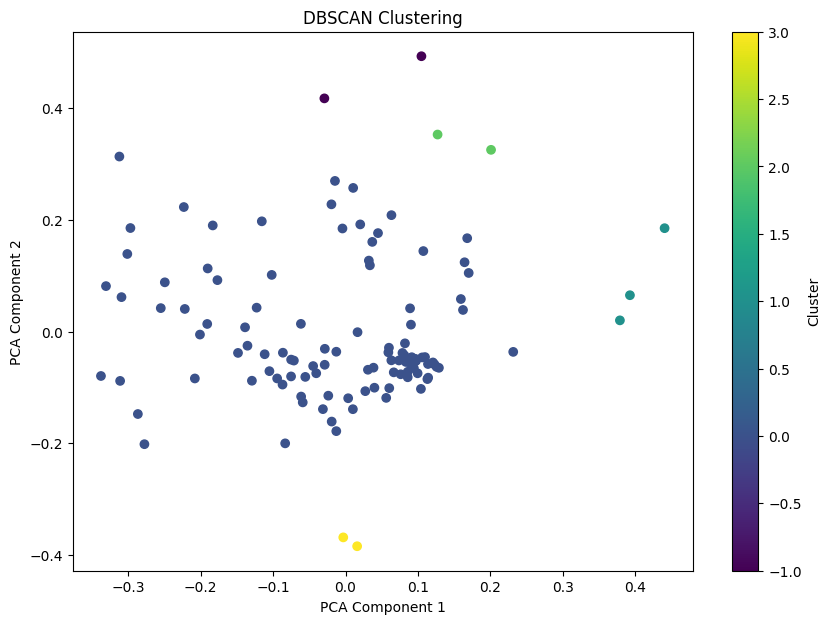

Cluster 0:
['Бывало ли у вас когда-нибудь такое странное ощущение?', 'Вот включили вы новую игру, проходите её, а когда вы пытаетесь вспомнить, что вам там понравилось больше всего, вы осознаёте странный момент, что больше всего вы запомнили в ней, это тот единственный враг, который вызывал у вас Гнев, страх или ещё какое чувство.', 'Возможно вам в игре понравилось ещё что-то, но ЕГО, вы запомнили очень ярко.', 'Каждое его появление провоцировало вас на эмоции.', 'Столь бурные, что вы сами того не ожидали.', 'И по итогу вы понимаете, что без этого врага игра была бы совсем другой.', 'Возможно легче, возможно хуже или интереснее.', 'И вам он нравится из-за этого.', 'НО при этом, вы ясно осознаёте, что вы ни желали бы больше сталкиваться с ним даже при перепрохождении и по возможности старались бы избегать встречи с ним.Наверняка у многих заядлых геймеров есть такие противники в разных играх.Я же сейчас хочу коснуться некоторых таких врагов с которыми сталкивались многие геймеры, в том ч

In [91]:
import pandas as pd

dfDBSCAN = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'cluster': clustersDBS})

plt.figure(figsize=(10, 7))
plt.scatter(dfDBSCAN['x'], dfDBSCAN['y'], c=dfDBSCAN['cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

for cluster in set(clustersDBS):
    print(f"Cluster {cluster}:")
    cluster_texts = [clean_sentences[i] for i in range(len(clustersDBS)) if clustersDBS[i] == cluster]
    print(cluster_texts)

**KMeans**

In [92]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5)
clustersKMeans = kmeans.fit_predict(X_pca)
clustersKMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 1, 3, 0, 0, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 0, 4, 2, 0, 2, 3, 2,
       0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 4, 0, 3, 1, 3,
       3, 3, 3, 0, 3, 2, 2, 0, 0, 2, 1, 3, 3, 3, 3, 1, 1, 0, 1, 0, 4, 1,
       0, 0, 3, 3, 0, 2, 0, 1, 0, 3, 3, 3, 3, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 3, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 0, 3, 3,
       3, 3, 2, 1, 3, 0, 2, 1, 1, 3, 3, 3, 1], dtype=int32)

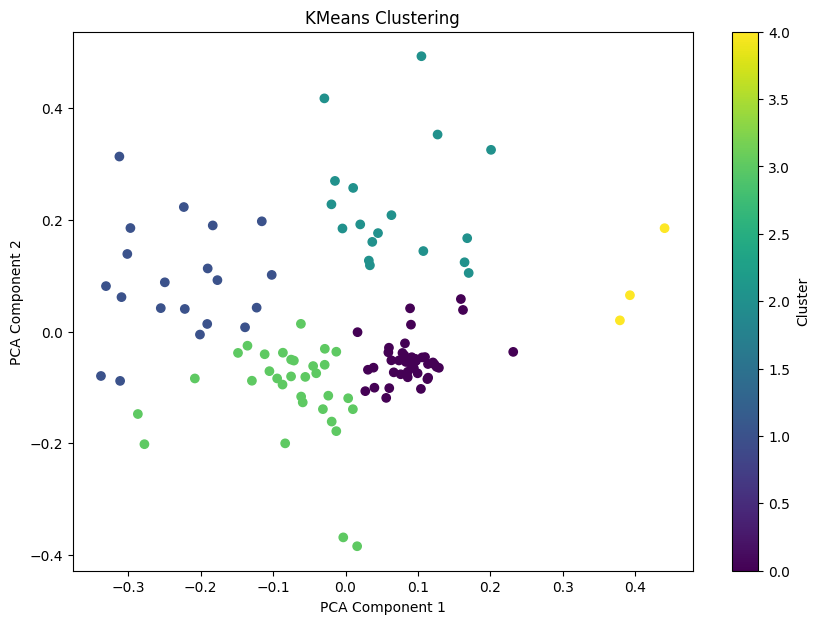

Cluster 0:
['Бывало ли у вас когда-нибудь такое странное ощущение?', 'Каждое его появление провоцировало вас на эмоции.', 'Столь бурные, что вы сами того не ожидали.', 'Возможно легче, возможно хуже или интереснее.', 'Мистер Икс и Немезис.', 'Столь ярким, что его образ знают даже те кто не играл в серию RE.', 'Он заставлял принимать молниеносные решения.', 'Что сделать?', 'Вдруг ты сглупил?', 'А появления его в гуманойдной форме, с преследованием я считаю было совсем мало.Однако этот момент не уменьшает культовости этого Тирана.', 'Ни кто не остался равнодушным к этим шагам за стеной.', 'Тяжёлым.', 'Увесистым.', 'Говорящим о том, что он за стеной и не дай бог он сейчас откроет дверь в ту комнату, где ты находишься.', 'И какое же облегчение ты получаешь когда слышишь, что он уходит вдаль.', 'Или же наоборот, вылупляешь глаза от того, что он реально зашёл не по скрипту к тебе и у тебя лишь 2 мысли, валить отсюда или что бы он тебя не заметил.', 'А уж что говорить про твою реакцию, когда 

In [94]:
dfKMeans = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'cluster': clustersKMeans})

plt.figure(figsize=(10, 7))
plt.scatter(dfKMeans['x'], dfKMeans['y'], c=dfKMeans['cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

for cluster in set(clustersKMeans):
    print(f"Cluster {cluster}:")
    cluster_texts = [clean_sentences[i] for i in range(len(clustersKMeans)) if clustersKMeans[i] == cluster]
    print(cluster_texts)

**Этап 4 - результаты анализа**

Выделить темы, по которым были построены кластеры

DBSCAN распределил предложения по кластерам довольно неравномерно

Кластер 0 - в него попало вступление к статье и описания статьи и врага

Кластер 1 - Что можно сделать, чтобы спастись от врага

Кластер 2 - То же самое

Кластер 3 - Два почти одинаковых по смыслу предложения

Кластер -1 - Оценка итогов некоего действия

KMeans распределил предложения по кластерам равномернее и куда ближе по смыслу.

Кластер 0 - Оценочные суждение и эмоции/эмоциональные высказвания

Кластер 1 - Вступление к статье

Кластер 2 - Описание возможностей противника и возможных действий против него

Кластер 3 - Эмоции, полученые автором от встреч с противником

Кластер 4 - то же, что и Кластер 1 в DBSCAN

В целом, мне показалось, что KMeans лучше справился с кластеризацией, хотя в кластеры 0 и 3 попали похожие по смыслу предложения (На визуализации видно, что эти кластеры близки). В обоих методах был выделен кластер с одними и теми же предложениями.